### Evaluation of Generative Adveserial Network for KDD

## The Method

1. Prepare data & Partition the data into 80-20 train-test split
2. Define Models & Parameters
3. Perform Cross-Validation on the training data
3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters
4. Evaluate the (re)trained models on the test data
5. Final evaluation of the models

![The Method](method.png)

Source: [scikit-learn.org - Cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-and-model-selection)

In [6]:
# Import libraries
import pandas as pd
import numpy as np
from pandas import DataFrame as df
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_pipeline

import tensorflow as tf
import keras
from keras import layers
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.models import Sequential
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

from pprint import pprint
from time import time

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5
CKP_PREFIX = 'KDD_'

np.random.seed(RANDOM_STATE)

# pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 1. Prepare data & Partition the data into 80-20 train-test split

Label Mapping: {'attack': 0, 'normal': 1}
Normal Label: 1
Attack Label: 0


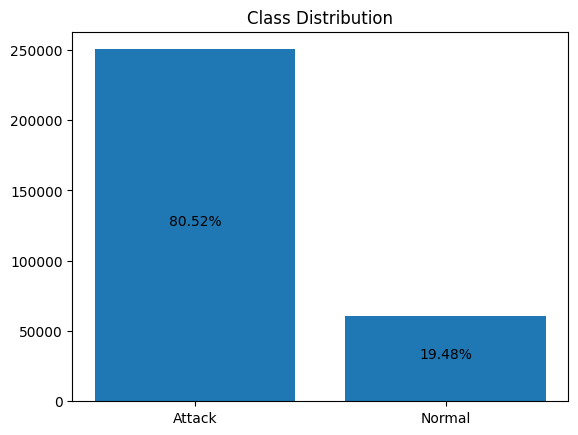

In [7]:
# Importing the dataset
path_to_data = '../data/kddcup/kddcup_data_corrected.csv'

# col names from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
col_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]
# from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
categorical_cols = [
    "protocol_type",
    "service",
    "flag",
    "land",
    "logged_in",
    "is_host_login",
    "is_guest_login",
]

# Read data (10 % subset of the original dataset)
data = pd.read_csv(path_to_data, names=col_names, header=None)

# Label encoding
data["label"] = data["label"].apply(lambda x: "attack" if x != "normal." else 'normal')
le = LabelEncoder()
y = le.fit_transform(data["label"])
X = data.drop("label", axis=1)

# Extract label mapping
label_mapping = {label: index for index, label in enumerate(le.classes_)}
normal_label = label_mapping['normal']
attack_label = label_mapping['attack']
print("Label Mapping:", label_mapping)
print("Normal Label:", normal_label)
print("Attack Label:", attack_label)

# Visualize class imbalance
plt.bar(["Attack", "Normal"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1] / total) * 100
normal_percentage = (data["label"].value_counts()[0] / total) * 100

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage:.2f}%', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage:.2f}%', ha='center', color='black')
plt.title("Class Distribution")
plt.show()

# create training and test partitions with 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Fit OneHotEncoder to learn categories from the training data. This is necessary to ensure that the same categories are used for random splits during cross-validation
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype="int8")
one_hot_encoder.fit(X_train[categorical_cols])
learned_categories = one_hot_encoder.categories_

# Define numerical columns & indices
num_cols = data.drop(categorical_cols, axis=1)
num_indices = [data.columns.get_loc(col) for col in num_cols.drop('label', axis=1).columns]
cat_indices = [data.columns.get_loc(col) for col in categorical_cols]

# Define preprocessing transformers and pipeline

# Numerical transformer. Scales numerical data using StandardScaler
numeric_transformer = imblearn_pipeline(
    steps=[("scaler", StandardScaler())], verbose=True
)

# Categorical transformer. Encodes categorical data using OneHotEncoder
categorical_transformer = imblearn_pipeline(
    steps=[
        (
            "onehot",
            OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False,
                categories=learned_categories,
                dtype="int8",
            ),
        )
    ],
    verbose=True,
)

# Define preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_indices),
        ("cat", categorical_transformer, cat_indices),
    ],
    verbose=True,
)


## Define GAN

In [12]:
# create generator model
def get_generator(latent_dim, data_dim):
    g = Sequential(name="generator")

    g.add(
        layers.Input(shape=(latent_dim,), name="input")
    )  # input layer to receive noise from latent space
    g.add(Dense(64))
    g.add(BatchNormalization(momentum=0.8))
    g.add(LeakyReLU(negative_slope=0.2))
    g.add(layers.Dropout(0.5))

    # Hidden layer 1: Upscale to a larger feature set
    g.add(Dense(256))
    g.add(BatchNormalization(momentum=0.8))
    g.add(LeakyReLU(negative_slope=0.2))
    g.add(layers.Dropout(0.5))

    # Hidden layer 2: Continue upscaling
    g.add(Dense(512))
    g.add(BatchNormalization(momentum=0.8))
    g.add(LeakyReLU(negative_slope=0.2))
    g.add(layers.Dropout(0.5))

    g.add(Dense(data_dim, activation="tanh"))  # data_dim == cols

    return g

# create discriminator model
def get_discriminator(data_dim):
    d = Sequential(name="discriminator")

    # Input layer
    d.add(layers.Input(shape=(data_dim,)))
    d.add(layers.Dense(128, kernel_initializer="he_uniform"))
    d.add(LeakyReLU(negative_slope=0.2))

    # Hidden layer 1
    d.add(layers.Dense(256, kernel_initializer="he_uniform"))
    d.add(layers.LeakyReLU(negative_slope=0.2))

    # Hidden layer 2
    d.add(layers.Dense(512, kernel_initializer="he_uniform"))
    d.add(layers.LeakyReLU(negative_slope=0.2))

    # Output layer: single probability score
    d.add(layers.Dense(1, activation="sigmoid"))

    # Output layer: single probability score
    d.add(layers.Dense(1, activation="sigmoid"))

    return d

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.seed_generator = keras.random.SeedGenerator(RANDOM_STATE)

    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_samples = data

        # Create random noise
        batch_size = tf.shape(real_samples)[0]  # Dynamically compute the batch size
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake samples
        fake_samples = self.generator(noise, training=True)

        # Combine fake and real samples and labels
        combined_samples = tf.concat([fake_samples, real_samples], axis=0)
       
        fake_labels = tf.zeros((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))
        labels = tf.concat([fake_labels, real_labels], axis=0)
       
        
        # Add random noise to the labels - important trick!
        # labels += 0.05 * keras.random.uniform(
        #     tf.shape(labels), seed=self.seed_generator
        # )      
        
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_samples, training=True)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # grads = [tf.clip_by_value(grad, -1.0, 1.0) for grad in grads]
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        
        # Train the generator
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1)) # Flip labels: real = fake
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(noise, training=True), training=False)
            g_loss =  self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)

        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result()
        }
    
    def test_step(self, data):
            # Unpack the data
            real_samples, real_labels = data
            batch_size = tf.shape(real_samples)[0]

            # Generate noise
            noise = tf.random.normal(shape=(batch_size, self.latent_dim))
            
            # Generate fake samples using the generator
            fake_samples = self.generator(noise, training=False)
            
            # Labels for fake samples
            fake_labels = tf.zeros((batch_size, 1))
            
            # Evaluate discriminator on real samples
            real_predictions = self.discriminator(real_samples, training=False)
            d_loss_real = self.loss_fn(real_labels, real_predictions)
            
            # Evaluate discriminator on fake samples
            fake_predictions = self.discriminator(fake_samples, training=False)
            d_loss_fake = self.loss_fn(fake_labels, fake_predictions)

            # Overall discriminator loss on test data
            d_loss = 0.5 * (d_loss_real + d_loss_fake)
            
            # Update the loss trackers
            self.d_loss_tracker.update_state(d_loss)
        
            
            return {
                "d_loss": self.d_loss_tracker.result(),
            }

### 2. Define Models and Perform Cross-Validation on the training data

In [13]:
def _gan(latent_dim=121, batch_size=32, epochs=10, data_dim=121):
      discriminator = get_discriminator(data_dim)
      generator = get_generator(latent_dim, data_dim)
      
      gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

      gan.compile(
            d_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
            g_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, clipvalue=1.0),
            loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
      )
      return gan, discriminator, generator

In [14]:
# Initialize cross-validation
kf = StratifiedKFold(n_splits=CROSS_VAL_SPLITS, shuffle=True, random_state=RANDOM_STATE)

f1_scores = []
precision_scores = []
recall_scores = []

# Define hyperparameters
EPOCHS = 10
BATCH_SIZE = 32

# for train_index, val_index in kf.split(X_train, y_train):
for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    print(f"\nFold {i+1}/{CROSS_VAL_SPLITS}")

    X_train_fold = X_train.iloc[train_index].copy()
    X_val_fold = X_train.iloc[val_index].copy()
    y_val_fold = y_train[val_index].copy()

    print("Fitting preprocessor...")
    # Fit preprocessor
    preprocessor.fit(X_train_fold)

    # transform data
    print("Transforming data...")
    X_train_fold = preprocessor.transform(X_train_fold)
    X_val_fold = preprocessor.transform(X_val_fold)
    print("Data transformed.")

    # check for nan
    print("nan values in X_train_fold: ", np.isnan(X_train_fold).any())

    # Define the GAN
    data_dim = X_train_fold.shape[1]
    gan, discriminator, _ = _gan(data_dim=data_dim)
    gan.build(input_shape=(None, data_dim))

    # Train the GAN
    print("Training GAN...")
    # early stopping
    cb_early_stopping_d = keras.callbacks.EarlyStopping(
        monitor="d_loss",
        mode="min",
        patience=4,
        restore_best_weights=True,
        # baseline=0.2,
    )

    gan.fit(
        X_train_fold,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[cb_early_stopping_d],
    )

    print("Predicting on validation set...")
    # Predict on validation set
    y_val_pred = discriminator.predict(X_val_fold)  # Predicted labels (0: inlier, 1: outlier)
    print("Predictions made.")

    print("Calculating metrics...")
    # Continuous scores from the discriminator
    anomalous_scores = discriminator.predict(X_val_fold[y_val_fold == attack_label], verbose=0)
    normal_scores = discriminator.predict(X_val_fold[y_val_fold == normal_label], verbose=0)

    # True labels
    y_true = np.concatenate([np.ones_like(anomalous_scores), np.zeros_like(normal_scores)])
    scores = np.concatenate([anomalous_scores, normal_scores])

    best_metric = 0
    best_threshold = 0

    # Calculate metrics
    for threshold in np.arange(0.1, 1, 0.001):
        current_metric = f1_score(y_true, scores < threshold)
        if current_metric > best_metric:
            best_metric = current_metric
            best_threshold = threshold

    # get all metrics
    f1 = f1_score(y_true, scores < best_threshold)
    precision = precision_score(y_true, scores < best_threshold)
    recall = recall_score(y_true, scores < best_threshold)

    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)


# Report mean and standard deviation of metrics
print("Cross-Validation Results:")
print(f"F1-Score: Mean={np.mean(f1_scores):.4f}, Std={np.std(f1_scores):.4f}")
print(
    f"Precision: Mean={np.mean(precision_scores):.4f}, Std={np.std(precision_scores):.4f}"
)
print(f"Recall: Mean={np.mean(recall_scores):.4f}, Std={np.std(recall_scores):.4f}")


Fold 1/5
Fitting preprocessor...
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
Transforming data...
Data transformed.
nan values in X_train_fold:  False
Training GAN...
Epoch 1/10
6221/6221 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - d_loss: 0.4941 - g_loss: 0.7677
Epoch 2/10
6221/6221 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - d_loss: 0.3654 - g_loss: 1.0942
Epoch 3/10
6221/6221 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - d_loss: 0.2802 - g_loss: 1.3934
Epoch 4/10
6221/6221 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - d_loss: 0.2156 - g_loss: 1.6378
Epoch 5/10
6221/6221 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - d_loss: 0.1656 - g_loss: 1.8783
Epoch 6/10
6221/6221 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - d_loss: 0.1270 - g_loss: 2.1273
Epoch 7/10
6221/6221 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - d

### 3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters

In [15]:
# Fit the preprocessor on the full training data
preprocessor.fit(X_train)

# Transform the filtered data without re-fitting
transformed_sample = preprocessor.transform(X_train)

# Check for NaNs
if np.isnan(transformed_sample).any():
    print("NaNs detected in the transformed data.")
else:
    print("No NaNs in the transformed data.")

 # Define the GAN
data_dim = transformed_sample.shape[1]
gan, discriminator, _ = _gan(data_dim=data_dim)
gan.build(input_shape=(None, data_dim))

# Train the GAN
print("Training GAN...")
# early stopping
cb_early_stopping_d = keras.callbacks.EarlyStopping(
    monitor="d_loss",
    mode="min",
    patience=10,
    restore_best_weights=False,
    baseline=0.2,
)

gan.fit(
    transformed_sample,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[cb_early_stopping_d],
)

# training time for 10 epochs = 8min 32s

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.1s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
No NaNs in the transformed data.
Training GAN...
Epoch 1/10
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - d_loss: 0.4518 - g_loss: 0.7878
Epoch 2/10
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - d_loss: 0.2912 - g_loss: 1.2304
Epoch 3/10
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - d_loss: 0.2054 - g_loss: 1.6599
Epoch 4/10
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - d_loss: 0.1464 - g_loss: 1.9939
Epoch 5/10
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - d_loss: 0.1048 - g_loss: 2.3119
Epoch 6/10
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - d_loss: 0.0762 - g_loss: 2.6287
Epoch 7/10
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - d_loss: 0.0556 - g_loss: 2.9506
Epoch 8/10
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 53

### 4. Final evaluation of the models on test set

Recall: 1.00
Precision: 0.81
F1: 0.89


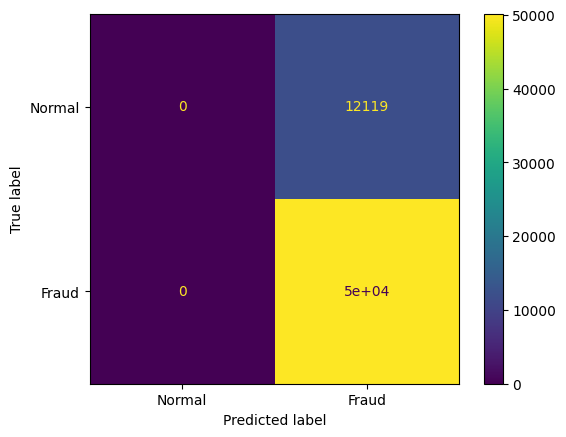

In [17]:
transformed_x_test = preprocessor.transform(X_test)

# Continuous scores from the discriminator
anomalous_scores = discriminator.predict(transformed_x_test[y_test == attack_label], verbose=0)
normal_scores = discriminator.predict(transformed_x_test[y_test == normal_label], verbose=0)

# True labels
y_true = np.concatenate([np.ones_like(anomalous_scores), np.zeros_like(normal_scores)])
scores = np.concatenate([anomalous_scores, normal_scores])

best_metric = 0
best_threshold = 0

# Calculate metrics
for threshold in np.arange(0.1, 1, 0.001):
    current_metric = f1_score(y_true, scores < threshold)
    if current_metric > best_metric:
        best_metric = current_metric
        best_threshold = threshold

# Evaluate the model
f1 = f1_score(y_true, scores < best_threshold)
precision = precision_score(y_true, scores < best_threshold)
recall = recall_score(y_true, scores < best_threshold)

print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1: {f1:.2f}")

# plot confusion matrix
cm = confusion_matrix(y_true, scores < best_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fraud"])
disp.plot()
plt.show()